In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()
%matplotlib inline


In [2]:
#%unload_ext vimception


In [3]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import pandas as pd
import numpy as np
import netCDF4
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import *

In [48]:
filename='/Users/ptg21/data/projects/TRANSCOM/N48_ancil_creation/ch2br2_jrates_redo//ch2br2_jrates_N48_regrid.nc'
ncfile1    = netCDF4.Dataset(filename)
lon1        = ncfile1.variables['longitude'][:]
lat1        = ncfile1.variables['latitude'][:] 
times1      = ncfile1.variables['tim']
jrates      = ncfile1.variables['CH2Br2_j_rate'][:,:,:,:]
nmonths, nlevels, ny1, nx1 = np.shape(jrates)

new_jrates = np.empty_like(jrates)
new_jrates_int = np.empty_like(jrates)

for ivar in range (0, ny1):
        new_jrates_int [:,:,ivar,:] = jrates[:,:, (ny1-1)-ivar,:]
        
for ivar in range (0,nlevels):
    new_jrates [:,ivar,:,:] = new_jrates_int[:,nlevels-ivar-1,:,:]

#nboundaries = nlevels + 1
#nx1 = len(lon1)
#ny1 = len(lat1)


In [5]:
filename='/Users/ptg21/data/projects/TRANSCOM/N48_ancil_creation/ch2br2_jrates/ch2br2_jrates_pressure_field_regrid_N48.nc'
ncfile2     = netCDF4.Dataset(filename)
lon2        = ncfile2.variables['longitude'][:]
lat2        = ncfile2.variables['latitude'][:] 
times2      = ncfile2.variables['tim']
pressure    = ncfile2.variables['Pressure'][:]

nx2 = len(lon2)
ny2 = len(lat2)
pressure_int = np.empty_like(pressure)

for ivar in range (0,ny2):
    pressure_int [:,:,ivar,:] = pressure[:,:,ny2-ivar-1,:]

pressure = np.empty_like(pressure)    

for ivar in range (0,nlevels):
    pressure [:,ivar,:,:] = pressure_int[:,nlevels-ivar-1,:,:]

ancil_pressure = pressure

In [6]:
# get file containing heights, pressures for L85 ancil
filename='/Users/ptg21/data/projects/TRANSCOM/N48_ancil_creation/xjcira.p.nc'
ncfile3     = netCDF4.Dataset(filename)

lon3         = ncfile3.variables['longitude'][:]
lat3         = ncfile3.variables['latitude'][:]
output_press = ncfile3.variables['p'][:]
hybrid_ht    = ncfile3.variables['hybrid_ht'][:]
times3       = ncfile3.variables['t']
nmonths3, nheights3, ny3, nx3 = np.shape(output_press)
print(nmonths3, nheights3, ny3, nx3 )

(12, 60, 73, 96)


In [7]:
# find matches between input pressure field and output pressure field
# data will be created using the ybrid ht corresponding to the output pressure

# find which model levels correspond to each height
height_match = np.empty([nmonths3, nheights3, ny3, nx3], dtype=np.int)

err_str=''

nyl=0
nyu=ny3

nxl=0
nxu=nx3

for imonth in range (0, nmonths3):
    print imonth
    for ilat in range(nyl, nyu):
        #print ilat
        for ilon in range (nxl, nxu):
            pold = ancil_pressure [imonth, :, ilat, ilon]
            pnew = output_press   [imonth, :, ilat, ilon] 
            # array for interpolated data
            res = np.zeros(nheights3, dtype=np.int)
                # for each new level, find corresponding pressure levels and interpolate OH concentration
                # need to check the case that there are two levels between the old levels.  think i did this!
            startlev=0
            # loop over levels required
            for newlev in range(startlev, len(pnew)):
                if pnew[newlev]>pold[0]:
                    res[newlev] = 0
                else:
                    # locate where in UM output pressure array each required pressure is
                    match_press_idx = np.abs(pnew[newlev] - pold).argmin()
                    res[newlev] = np.int(match_press_idx)
                    startlev=newlev # once have found pressure no need to start from below this level again
            height_match[imonth, :, ilat, ilon] = res[:]   
    #print res
np.save('height_match_N48L60_hossaini_input_press.npy',height_match)

0
1
2
3
4
5
6
7
8
9
10
11


In [70]:
def interp_lin_val(xnew, x, y, idx):
    # x,y arrays
    # xnew is the new xvalue
    # returns ynew as a linear interpolation
    # returns a value
    dx = xnew - x[idx]
    dy_dx = (y[idx]-y[idx+1])/(x[idx]-x[idx+1]) 
    # calculate a value at thew intermediate pressure
    return y[idx]+dy_dx*dx

In [78]:
interp_jrates   = np.empty([nmonths3, nheights3, ny3, nx3])
for imonth in range (0, nmonths3):
    print imonth
    for ilat in range(nyl, nyu):
        for ilon in range (nxl, nxu):
            xold  = ancil_pressure [imonth, :, ilat, ilon] # array 
            yold  = new_jrates     [imonth, :, ilat, ilon]

            for ilev in range(0, nheights3-1):
                    xnew = output_press[imonth, ilev, ilat, ilon]
                    interp_jrates[imonth,  ilev, ilat, ilon] = interp_lin_val(xnew, 
                                                                              xold, 
                                                                              yold,                                                                             
                                                                              min(height_match[imonth, ilev, ilat, ilon],58))


0
1
2
3
4
5
6
7
8
9
10
11


In [79]:
np.save('interp_ch2br2_rates.npy',interp_jrates)

In [80]:
interp_ch2br2_rates=np.load('interp_ch2br2_rates.npy')

In [81]:
%%bash
rm -Rf N96_L85_ch2br2_jrates.nc

In [82]:
from netCDF4 import Dataset
import time
# Create HDF5 *format*, classic *model*
dataset = Dataset('N96_L85_ch2br2_jrates.nc', 'w', format='NETCDF4')

# Global Attributes
dataset.description = 'TEST NETCDF-CF COMPLIANT SCRIPT'
dataset.history = 'Created ' + time.ctime(time.time())
dataset.source = ''
dataset.Conventions = 'CF-1.0'
dataset.standard_name_vocabulary='CF-1.0'

height = dataset.createDimension('hybrid_ht', nheights3)
height     = dataset.createVariable('hybrid_ht',    np.int32,   ('hybrid_ht',))

time  = dataset.createDimension('time',      None)
time  = dataset.createVariable('time',       'f8', ('time',)) # or can use np as below

lat   = dataset.createDimension('latitude',  ny3)
lat   = dataset.createVariable('latitude',   np.float32, ('latitude',))

lon   = dataset.createDimension('longitude', nx3)
lon   = dataset.createVariable('longitude',  np.float32, ('longitude',))

jratesout = dataset.createVariable('jrate', np.float32, ('time','hybrid_ht','latitude', 'longitude',))

lon[:]   = lon3[:]
lat[:]   = lat3[:]
height[:] = hybrid_ht[:]
time[:]  = times3[:]

jratesout[:,:,:,:] = interp_ch2br2_rates[:,:,:,:]

# Variable Attributes
lat.standard_name = 'latitude'
lat.units = 'degrees_north'
lat.cartesian_axis = "Y"
lat.axis = 'Y'
lat.actual_range = -90.0, 90.0

lon.standard_name = 'longitude'
lon.units = 'degrees_east'
lon.cartesian_axis = "X"
lon.axis = "X"
lat.actual_range = 0.0, 360.0

jratesout.units = 's-1'
jratesout.standard_name='Ch2Br2 photolysis rate'

height.units = 'm'
height.axis='Z'
height.positive='up'
height.standard_name = 'hybrid_pressure_levels'


time.standard_name = 'time'
time.long_name = 'time'
time.units = 'days since 1999-12-01 00:00:00'
time.calendar = '360_day'
time.axis = 'T'
print ('success')
dataset.close()

success


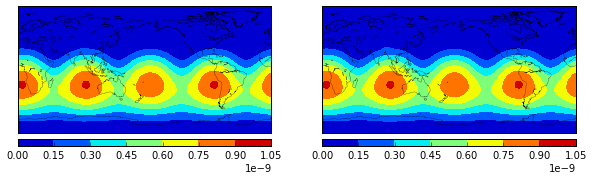

In [85]:
# check plot for comp with ncview create the figure and axes instances.
fig = plt.figure(num=2,figsize=(10,15),dpi=300)
zvar=1
plt.subplot(1,2,1)
m1 = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360.,resolution='c')
lons1, lats1 = m1.makegrid(nx2, ny2)
x1,y1 = m1(lons1, lats1)
im1 = m1.contourf(x1, y1, new_jrates[0,zvar,:,:])
m1.colorbar(im1,location='bottom',pad="5%")
m1.drawcoastlines(linewidth=0.25)


plt.subplot(1,2,2)
m2 = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360.,resolution='c')
lons2, lats2 = m2.makegrid(nx2, ny2)
x2,y2 = m1(lons2, lats2)
im2 = m2.contourf(x2, y2, interp_ch2br2_rates[0,zvar,:,:])
m2.colorbar(im1,location='bottom',pad="5%")
m2.drawcoastlines(linewidth=0.25)

# plt.subplot(1,3,3)
# m3 = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360.,resolution='c')
# lons3, lats3 = m3.makegrid(nx3, ny3)
# x3,y3 = m1(lons3, lats3)
# im3 = m3.contourf(x3, y3, jrates[0,59-zvar,:,:])
# m3.colorbar(im1,location='bottom',pad="5%")
# m3.drawcoastlines(linewidth=0.25)


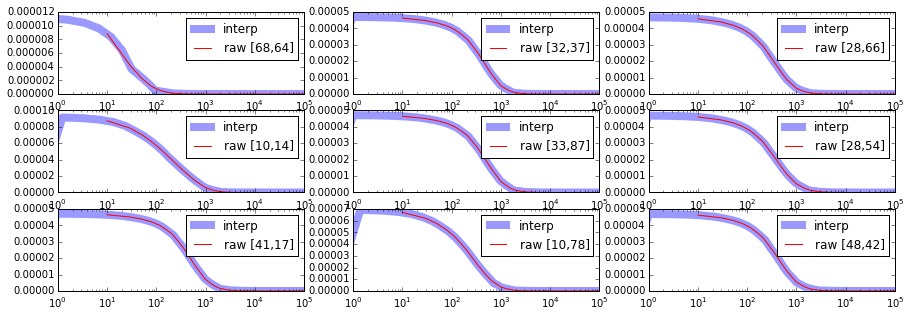

In [84]:
from random import randint

plt.figure(figsize=(15,5))

for ivar in range (1,10):
    plt.subplot(3,3,ivar)
    month=randint(0,11)
    lat=randint(0,ny1-1)
    lon=randint(0,nx1-1)
    plt.semilogx(output_press[month,:,lat,lon],interp_ch2br2_rates[month,:,lat,lon], lw=8, alpha=0.4, label='interp')
    plt.semilogx(ancil_pressure[month,:,lat,lon],new_jrates[month,:,lat,lon],'r-', label='raw [' + str(lat)+","+str(lon)+"]")
    plt.xlim([1,1e5])
    plt.legend()